This program creates a class `County_AgWr` that imports and models weather and agricultural data on the county level. This notebook focuses on Colorado, but with minimal user input it could examine weather and agricultural data throughout the U.S.

Instantiations of the class `County_AgWr` will have multiple `pandas.DataFrame`s self-referenced: 
*  `.wr` for weather.
*  `.crops` for crops.
*  `.models` for models and their statistics.

There are specific methods for creating and analyzing these dataframes:
*  `.add_weather()` scrapes, cleans, and concatenates weather data from the [Western Regional Climate Center](https://wrcc.dri.edu).
*  `.add_crops()` imports, wrangles, and merges crop data already downloaded as CSVs from the[ National Agricultural Statistics Service](https://quickstats.nass.usda.gov/) of the USDA.
*  `.crop_weather()` merges the crops yield data with weather data. Only those crops with more than 40 years of yield data are saved as a .csv and ready for X, y modeling.
*  `.fit_models(thru_month_num)` fits regression models from the `.crop_weather` CSVs with X as weather data for the year through month number ("thru_month_num") of the year,  and y as crop yields. Only those models with r2 scores > 0.02 are saved to `.models`.
*  `.fit_all_models()` cycles through the possible months to choose (April to October) and saves all models with r2 scores > 0.02 to `.models`.



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import urllib.request
from bs4 import BeautifulSoup
import re
import time
import os
import geopandas
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import (LinearRegression, Ridge, RidgeCV, Lasso, 
                                  ElasticNet, ElasticNetCV, BayesianRidge)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
class County_AgWr:
    """County instance to join crop and weather data and predict this year's yield."""
    def __init__(self, name):
        self.name = name
        self.wr = pd.DataFrame
        self.crops = pd.DataFrame
        self.models = pd.DataFrame(columns=['crop', 'thru_month', 'model', 
                                            'r2_score', 'rmse'])
        self.crop_doc_count = 0

    def add_weather(self):
        if os.path.exists(f'../data/inter/{self.name}_wr.csv'):
            wr_cat = pd.read_csv(f'../data/inter/{self.name}_wr.csv', index_col='Year')
        else:
            counties = pd.read_csv(f'../data/raw/counties_ag.csv', index_col=[0])
            counties['Station ID'] = counties['Station ID'].astype(int)
            county = counties[counties['County'] == self.name]
            id = county.iloc[0, 2]
            urls = {'-p':f'https://wrcc.dri.edu/WRCCWrappers.py?sodxtrmts+0{id}+por+por+pcpn+none+msum+5+01+F',
                    '-txa':f'https://wrcc.dri.edu/WRCCWrappers.py?sodxtrmts+0{id}+por+por+maxt+none+mave+5+01+F',
                    '-taa':f'https://wrcc.dri.edu/WRCCWrappers.py?sodxtrmts+0{id}+por+por+avgt+none+mave+5+01+F',
                    '-tna':f'https://wrcc.dri.edu/WRCCWrappers.py?sodxtrmts+0{id}+por+por+mint+none+mave+5+01+F',
                    '-txm':f'https://wrcc.dri.edu/WRCCWrappers.py?sodxtrmts+0{id}+por+por+maxt+none+mmax+5+01+F',
                    '-tnm':f'https://wrcc.dri.edu/WRCCWrappers.py?sodxtrmts+0{id}+por+por+mint+none+mmin+5+01+F'
                    }   ## listed out, as the string formatting seemed to get lost in the pd.read_csv function.
            wr_cat = pd.DataFrame()
            for key, value in urls.items():
                id = county.iloc[0, 2]
                result = requests.get(value)
                soup = BeautifulSoup(result.text, 'html.parser')
                table = soup.find('table')
                data = pd.read_html(str(table))
                df = data[0]
                df.columns = df.iloc[0]
                df = df.drop([0])
                df = df.iloc[-68:-8, :]
                df = df.rename(columns={'YEAR(S)':'Year'})
                df['Year'] = pd.to_datetime(df['Year'], format='%Y')
                df = df.set_index('Year')
                df = df.dropna(axis=1)
                df = df.replace(to_replace='-----', value=np.nan)
                df = df.astype('float64')
                df = df.fillna(df.mean().round(2))
                cols_to_drop = ['NOV', 'DEC', 'ANN']
                df.drop(columns=cols_to_drop, inplace=True)
                df = df.add_suffix(key)
                wr_cat = pd.concat([wr_cat, df], axis=1)
                print(f'Weather data from {self.name.title()} County saved.')
                time.sleep(1.7)
            wr_cat.to_csv(f'../data/inter/{self.name}_wr.csv')
        self.wr = wr_cat
        print(f'Weather added to `{self.name.lower()}.wr`')
    
    def add_crops(self):
        """Imports and cleans up ag-survey CSV files."""
        crops = ['corn', 'barley', 'beans', 'oats', 'potatoes', 'sorghum', 
                 'sunflowers', 'wheat']
        for crop in crops:
            df = pd.read_csv(f'../data/raw/{crop}_colo.csv')
            col_to_drop = ['Program', 'Period', 'Week Ending', 'Geo Level', 'State', 
                            'State ANSI', 'Zip Code', 'watershed_code', 
                            'Watershed', 'Data Item', 'Domain', 'Domain Category', 
                            'Region', 'CV (%)']
            df.drop(col_to_drop, axis=1, inplace=True)
            df = df[(df['Value'] != ' (D)')&(df['Value'] != ' (Z)')]
            df.replace(to_replace=r',', value='', regex=True, inplace=True)
            df['Value'] = df['Value'].astype('int')
            df.rename(columns={'Value':f'Yield_{crop}'}, inplace=True)
            df['Year'] = pd.to_datetime(df['Year'], format='%Y')
            df = df[df['County'] == self.name]
            df2 = df.iloc[:, [0,3,-1]]
            if self.crop_doc_count == 0:
                self.crops = df2
            else:
                self.crops = pd.merge(left=self.crops, right=df2, 
                                            how='left', on=['Year', 'County'])
            self.crop_doc_count += 1
            print(f'{self.name.title()} County grows {crop}.')
        self.crops.set_index('Year', inplace=True)
        print(f'Crops added to `{self.name.lower()}.crops`')

    def crop_weather(self):
        """Combines weather df with crop yields with >40 non-null values."""
        crops = ['corn', 'barley', 'beans', 'oats', 'potatoes', 'sorghum', 
                 'sunflowers', 'wheat']
        for crop in crops:
            cp_y = self.crops[f'Yield_{crop}'].dropna()
            df = pd.merge(left=cp_y, right=self.wr, 
                          how='left', left_index=True, right_index=True)
            if len(df) < 40:
                continue
            else:
                df2 = df
                df2.to_csv(f'../data/proc/{self.name}_{crop}.csv')
                print(f'{self.name}_{crop}  ' + str(df2.shape))

    def fit_models(self, thru_month_num=(datetime.now().month - 1)):
        """Takes crop_weather outputs through month (chosen by thru_month_num) 
        and fits regression models. Saves those models with r2 scores > 0.1."""
        regressors = [LinearRegression(), Ridge(), RidgeCV(), Lasso(),
              ElasticNet(), BayesianRidge(), RandomForestRegressor(), 
              GradientBoostingRegressor(), DecisionTreeRegressor(), SVR()]
        crops = ['corn', 'barley', 'beans', 'oats', 'potatoes', 'sorghum', 
                 'sunflowers', 'wheat']
        for crop in crops:
            if os.path.exists(f'../data/proc/{self.name}_{crop}.csv'):
                df = pd.read_csv(f'../data/proc/{self.name}_{crop}.csv', index_col='Year')
                suffixes = ['-p', '-txa', '-taa', '-tna', '-txm', '-tnm']
                col_2_drop = {4:['MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT'],
                            5:['JUN', 'JUL', 'AUG', 'SEP', 'OCT'],
                            6:['JUL', 'AUG', 'SEP', 'OCT'],
                            7:['AUG', 'SEP', 'OCT'],
                            8:['SEP', 'OCT'],
                            9:['OCT'],
                            10:[]}
                col_d = col_2_drop[thru_month_num]
                for col in col_d:
                    for suf in suffixes:
                        cs = col + suf
                        df.drop(columns=cs, axis=1, inplace=True)
                X = df.iloc[:, 1:]
                y = df.iloc[:, 0]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)
                print(f'{crop} modeled...')
                for reg in regressors:
                    reg.fit(X_train, y_train) 
                    name = re.split("[(]", str(reg))[0]
                    y_pred = reg.predict(X_test)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
                    r2 = r2_score(y_test, y_pred).round(3)
                    # print(f'{crop} {name} modeled.')
                    if r2 > 0.02:
                        new_row = {'crop':crop, 'thru_month':thru_month_num, 'model':name, 'r2_score':r2,
                                    'rmse':rmse}
                        self.models = self.models.append(new_row, ignore_index=True)
                    else:
                        continue
            else:
                continue
        print('Fit_models finished.')
    
    def fit_all_models(self):
        for i in range(4, 11):
            self.fit_models(thru_month_num=i)
        self.models.to_csv(f'../models/lists/{self.name}_model_list.csv')
        print('April through October models finished.')
        
    def make_map(self):
        colo = geopandas.read_file('../data/gis/Colorado_County_Boundaries.shp')
        cntymap = colo[colo['COUNTY'] == self.name]
        fig = plt.figure(1, figsize=(12,12))
        ax = fig.add_subplot()
        colo.boundary.plot(ax=ax, color='Gray', linewidth=.8)
        cntymap.plot(ax=ax, color='royalblue', alpha=1)
    

To start, we need to choose a county as a capitalized string as an argument to `County_AgWr('NAME')`:

In [4]:
# counties = pd.read_csv(file_path + '/Data/raw/counties_ag.csv')
file_path = '../data/raw/'
counties = pd.read_csv(file_path + 'counties_ag.csv')
choose_county = list(counties['County'])
choose_county

['KIT CARSON',
 'LINCOLN',
 'ADAMS',
 'ARAPAHOE',
 'KIOWA',
 'LOGAN',
 'PROWERS',
 'SEDGWICK',
 'WASHINGTON',
 'MESA',
 'PHILLIPS',
 'WELD',
 'YUMA',
 'LARIMER',
 'MORGAN',
 'CHEYENNE',
 'ELBERT',
 'MONTEZUMA',
 'OTERO',
 'BACA',
 'DOLORES',
 'DOUGLAS',
 'LA PLATA',
 'LAS ANIMAS',
 'BOULDER',
 'MOFFAT',
 'PUEBLO',
 'ROUTT',
 'DELTA',
 'BENT',
 'SAN MIGUEL']

In [3]:
boulder = County_AgWr('BOULDER')
boulder.name

'BOULDER'

In [5]:
boulder.add_weather()

Weather added to `boulder.wr`


In [6]:
boulder.wr.head()

,JAN-p,FEB-p,MAR-p,APR-p,MAY-p,JUN-p,JUL-p,AUG-p,SEP-p,OCT-p,...,JAN-tnm,FEB-tnm,MAR-tnm,APR-tnm,MAY-tnm,JUN-tnm,JUL-tnm,AUG-tnm,SEP-tnm,OCT-tnm
Year,,,,,,,,,,,,,,,,,,,,,
1960-01-01,0.27,0.83,0.58,1.09,3.92,0.66,0.44,0.25,0.48,1.87,...,-12.0,-19.0,-18.0,20.0,29.0,42.0,48.0,42.0,35.0,25.0
1961-01-01,0.12,0.47,2.91,0.72,4.63,1.57,0.83,1.50,3.89,0.69,...,-16.0,5.0,6.0,18.0,32.0,43.0,45.0,48.0,28.0,22.0
1962-01-01,1.06,0.40,0.30,0.50,1.47,2.09,1.61,0.55,0.56,1.11,...,-34.0,-22.0,-14.0,17.0,24.0,41.0,49.0,39.0,30.0,26.0
1963-01-01,0.68,0.27,1.25,0.01,0.29,4.33,0.59,2.22,1.12,0.25,...,-34.0,2.0,-4.0,20.0,33.0,43.0,49.0,52.0,39.0,31.0
1964-01-01,0.10,0.21,0.97,1.06,1.66,1.28,0.24,0.57,0.09,0.05,...,-4.0,-9.0,5.0,14.0,30.0,40.0,50.0,38.0,28.0,20.0


In [7]:
boulder.add_crops()

/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wi

Boulder County grows corn.
Boulder County grows barley.
Boulder County grows beans.
Boulder County grows oats.
Boulder County grows potatoes.
Boulder County grows sorghum.
Boulder County grows sunflowers.
Boulder County grows wheat.
Crops added to `boulder.crops`


/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wi

In [8]:
boulder.crops.head()

,County,Yield_corn,Yield_barley,Yield_beans,Yield_oats,Yield_potatoes,Yield_sorghum,Yield_sunflowers,Yield_wheat
Year,,,,,,,,,
2019-01-01,BOULDER,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,BOULDER,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01,BOULDER,153,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01,BOULDER,173,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01,BOULDER,155,91.0,NaN,NaN,NaN,NaN,NaN,51.0


In [9]:
boulder.crop_weather()

BOULDER_corn  (50, 61)
BOULDER_barley  (46, 61)
BOULDER_beans  (41, 61)
BOULDER_oats  (40, 61)
BOULDER_wheat  (44, 61)


In [4]:
boulder.fit_all_models()

corn modeled...
barley modeled...
beans modeled...
oats modeled...


/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72094.8694189247, tolerance: 284.01875
  model = cd_fast.enet_coordinate_descent(


wheat modeled...
Fit_models finished.
corn modeled...
barley modeled...
beans modeled...
oats modeled...


/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21486.598673463108, tolerance: 284.01875
  model = cd_fast.enet_coordinate_descent(


wheat modeled...
Fit_models finished.
corn modeled...
barley modeled...
beans modeled...
oats modeled...


/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13471.22756060755, tolerance: 284.01875
  model = cd_fast.enet_coordinate_descent(


wheat modeled...
Fit_models finished.
corn modeled...
barley modeled...
beans modeled...


/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3376.100909848534, tolerance: 284.01875
  model = cd_fast.enet_coordinate_descent(


oats modeled...
wheat modeled...
Fit_models finished.
corn modeled...
barley modeled...
beans modeled...


/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13787.416422111814, tolerance: 284.01875
  model = cd_fast.enet_coordinate_descent(


oats modeled...
wheat modeled...
Fit_models finished.
corn modeled...
barley modeled...
beans modeled...


/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7641.328800300171, tolerance: 284.01875
  model = cd_fast.enet_coordinate_descent(


oats modeled...
wheat modeled...
Fit_models finished.
corn modeled...


/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5194889400381726, tolerance: 3.324990000000001
  model = cd_fast.enet_coordinate_descent(


barley modeled...
beans modeled...


/Users/cdevoe/PycharmProjects/Project_AgWr/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1124.2899071179545, tolerance: 284.01875
  model = cd_fast.enet_coordinate_descent(


oats modeled...
wheat modeled...
Fit_models finished.
April through October models finished.


In [5]:
boulder.models

,crop,thru_month,model,r2_score,rmse
0,corn,4,RandomForestRegressor,0.079,19.67
1,barley,4,RandomForestRegressor,0.292,14.97
2,barley,4,GradientBoostingRegressor,0.533,12.16
3,barley,4,DecisionTreeRegressor,0.176,16.15
4,wheat,4,RandomForestRegressor,0.397,6.27
5,wheat,4,GradientBoostingRegressor,0.369,6.41
6,wheat,4,DecisionTreeRegressor,0.285,6.83
7,corn,5,RandomForestRegressor,0.351,16.51
8,corn,5,GradientBoostingRegressor,0.335,16.72
9,barley,5,RandomForestRegressor,0.187,16.05


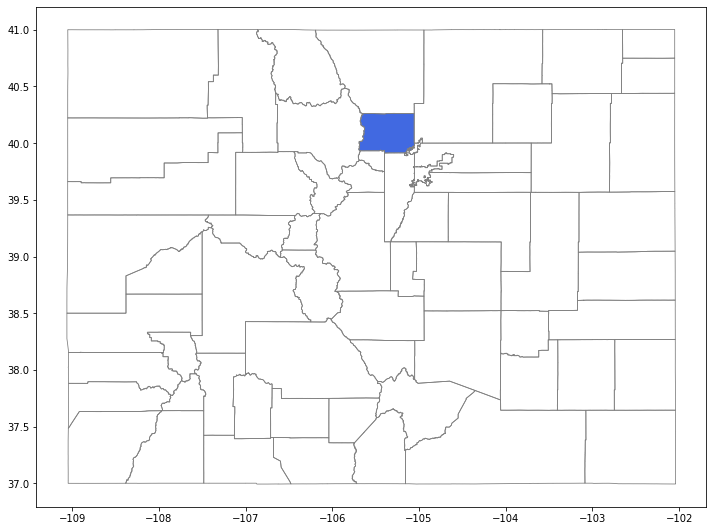

In [6]:
boulder.make_map()

In [ ]:
os.listdir(file_path + '/Data/inter')